<a href="https://colab.research.google.com/github/yashika-811/project_elavate/blob/main/music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib librosa soundfile scikit-learn tensorflow==2.* tqdm



In [3]:
import librosa
import soundfile as sf
import os

# Create a small dataset folder
os.makedirs("mini_dataset/blues", exist_ok=True)
os.makedirs("mini_dataset/classical", exist_ok=True)

# Download 2 sample tracks
y1, sr1 = librosa.load(librosa.ex('trumpet'))
sf.write("mini_dataset/blues/sample1.wav", y1, sr1)

y2, sr2 = librosa.load(librosa.ex('brahms'))
sf.write("mini_dataset/classical/sample2.wav", y2, sr2)

print("Mini dataset created:", os.listdir("mini_dataset"))


Mini dataset created: ['blues', 'classical']


In [4]:
import numpy as np
import librosa
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# constants
SR = 22050
DURATION = 3
SAMPLES_PER_SEGMENT = SR * DURATION
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512

def extract_mfcc(fp):
    y, sr = librosa.load(fp, sr=SR)
    if len(y) < SAMPLES_PER_SEGMENT:
        y = np.pad(y, (0, SAMPLES_PER_SEGMENT - len(y)))
    else:
        y = y[:SAMPLES_PER_SEGMENT]
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    return mfcc

X, y = [], []
genres = os.listdir("mini_dataset")

for genre in genres:
    files = os.listdir(f"mini_dataset/{genre}")
    for file in files:
        path = f"mini_dataset/{genre}/{file}"
        mfcc = extract_mfcc(path)
        X.append(mfcc)
        y.append(genre)

X = np.array(X)[..., np.newaxis]
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", le.classes_)


X shape: (2, 40, 130, 1)
y shape: (2, 2)
Classes: ['blues' 'classical']


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

input_shape = X.shape[1:]
num_classes = y.shape[1]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 130, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 130, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,954 (398.26 KB)

 Trainable params: 101,506 (396.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
history = model.fit(
    X, y,
    validation_split=0.2,   # 80% train, 20% validation
    epochs=15,
    batch_size=2,
    verbose=1
)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - loss: 2.9009 - val_accuracy: 1.0000 - val_loss: 0.0282
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.0000e+00 - loss: 1.6568 - val_accuracy: 1.0000 - val_loss: 0.0397
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0000e+00 - loss: 1.0495 - val_accuracy: 1.0000 - val_loss: 0.0504
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.0000e+00 - loss: 1.5723 - val_accuracy: 1.0000 - val_loss: 0.0598
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.0000e+00 - loss: 0.9522 - val_accuracy: 1.0000 - val_loss: 0.0694
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.0000e+00 - loss: 0.7352 - val_accuracy: 1.0000 - val_loss: 0.0795
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.0000e+00 - loss: 0.7520 - val_accuracy: 1.0000 - val_loss: 0.0893
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0000e+00 - loss: 1.4345 - val

In [18]:
import librosa

# Load built-in demo audio file (trumpet)
audio_path = librosa.example('trumpet')

print("Demo audio path:", audio_path)


Demo audio path: /root/.cache/librosa/sorohanro_-_solo-trumpet-06.ogg


In [20]:
# Use the demo trumpet audio
file_path = audio_path   # from librosa.example('trumpet')

features = extract_mfcc(file_path)
features = features.reshape(1, 40, 130, 1)  # match model input

prediction = model.predict(features)
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)

# Map predicted index back to genre
# class_labels = train_generator.class_indices # This caused the NameError
class_labels = le.classes_ # Use le.classes_ instead

print("Predicted genre:", class_labels[predicted_class])
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted genre: classical
Confidence: 0.97381073


In [22]:
from google.colab import files
uploaded = files.upload()   # Click "Choose File" and select your .wav file
file_path = list(uploaded.keys())[0]


Saving my_song.wav to my_song (1).wav


In [25]:
# Step 1: Extract MFCC features
features = extract_mfcc(file_path) # Corrected function name
features = features.reshape(1, 40, 130, 1)  # match the input shape of your CNN

# Step 2: Predict genre
prediction = model.predict(features)
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)

# Step 3: Map index to genre
# class_labels = train_generator.class_indices # This caused the NameError
# class_labels = {v: k for k, v in class_labels.items()} # This is also not needed
class_labels = le.classes_ # Use le.classes_ instead

# Step 4: Print results
print("Predicted genre:", class_labels[predicted_class])
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted genre: classical
Confidence: 0.7682447


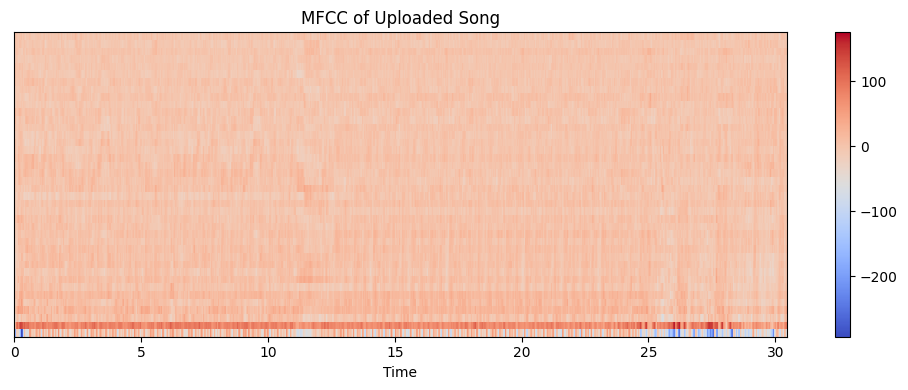

In [26]:
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(file_path)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC of Uploaded Song')
plt.tight_layout()
plt.show()
